In [1]:
# importing packages
import pandas as pd 
import numpy as np 

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')

from matplotlib.pyplot import figure
matplotlib.rcParams['figure.figsize'] = (12,8)

import seaborn as sns 
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")

In [2]:
# importing packages
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

In [3]:
# importing data
data = pd.read_csv('Final_Chicago_Traffic_Crashes_Cleaned.csv') 
display(data.shape)
display(data.info())
display(data.head())

(517457, 24)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517457 entries, 0 to 517456
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   POSTED_SPEED_LIMIT       517457 non-null  int64  
 1   TRAFFIC_CONTROL_DEVICE   517457 non-null  object 
 2   DEVICE_CONDITION         517457 non-null  object 
 3   WEATHER_CONDITION        517457 non-null  object 
 4   LIGHTING_CONDITION       517457 non-null  object 
 5   FIRST_CRASH_TYPE         517457 non-null  object 
 6   TRAFFICWAY_TYPE          517457 non-null  object 
 7   ALIGNMENT                517457 non-null  object 
 8   ROADWAY_SURFACE_COND     517457 non-null  object 
 9   ROAD_DEFECT              517457 non-null  object 
 10  REPORT_TYPE              517457 non-null  object 
 11  CRASH_TYPE               517457 non-null  object 
 12  DAMAGE                   517457 non-null  object 
 13  PRIM_CONTRIBUTORY_CAUSE  517457 non-null  object 
 14  SEC_

None

,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,...,SEC_CONTRIBUTORY_CAUSE,STREET_NO,STREET_DIRECTION,STREET_NAME,BEAT_OF_OCCURRENCE,NUM_UNITS,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LOCATION
0,35,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,ONE-WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,UNABLE TO DETERMINE,2158,N,MARMORA AVE,2515.0,2.0,17,4,7,POINT (-87.773287883007 41.919663832993)
1,35,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,NOT APPLICABLE,8301,S,CICERO AVE,834.0,2.0,16,6,6,POINT (-87.740953581987 41.741803598989)
2,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,FAILING TO YIELD RIGHT-OF-WAY,1632,E,67TH ST,331.0,3.0,10,6,7,POINT (-87.585022352022 41.773455972008)
3,30,NO CONTROLS,NO CONTROLS,CLEAR,DARKNESS,PARKED MOTOR VEHICLE,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,UNABLE TO DETERMINE,110,E,51ST ST,224.0,2.0,1,7,7,POINT (-87.622114914961 41.802118543011)
4,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,UNABLE TO DETERMINE,8301,S,CICERO AVE,834.0,2.0,22,5,3,POINT (-87.740953581987 41.741803598989)


In [4]:
# Target Variable

data['CRASH_TYPE'].value_counts(normalize = True)

NO INJURY / DRIVE AWAY              0.750563
INJURY AND / OR TOW DUE TO CRASH    0.249437
Name: CRASH_TYPE, dtype: float64

In [5]:
# Creating a Random Sample of the Data

sample_data = data.sample(n = 51746)

In [6]:
# Splitting Sample Data

y = sample_data['CRASH_TYPE']
X = sample_data.drop(['CRASH_TYPE'], axis=1)

In [7]:
# Train Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [8]:
# Transforming and Standardizing Data

numeric_features = ['POSTED_SPEED_LIMIT', 'STREET_NO',
                   'BEAT_OF_OCCURRENCE', 'NUM_UNITS',
                   'CRASH_HOUR', 'CRASH_DAY_OF_WEEK',
                   'CRASH_MONTH']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = ['TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
                       'WEATHER_CONDITION', 'LIGHTING_CONDITION',
                       'TRAFFICWAY_TYPE', 'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT',
                       'REPORT_TYPE', 'DAMAGE',
                       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE',
                       'STREET_DIRECTION', 'STREET_NAME']

categorical_transformer = OneHotEncoder(handle_unknown='ignore')


preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                               ('cat', categorical_transformer, categorical_features)])

X_train_tf = preprocessor.fit_transform(X_train)
X_test_tf = preprocessor.transform(X_test)

In [9]:
# Creating a function that will fit, predict and return classification/confusion matrices for the training/test sets

def run_model(model, X_train, X_test, y_train, y_test, 
              classes = None, normalize = 'true', 
              cmap = 'Blues', label = ''):
    
    model.fit(X_train, y_train)
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)
    
    # print training classification report 
    header = label + " CLASSIFICATION REPORT TRAINING "
    dashes = "---" * 20
    print(dashes, header, dashes, sep = '\n')
    print(classification_report(y_train, y_hat_train))
    
    # display training figures 
    fig, axes = plt.subplots(figsize=(20, 10))
    matrices_train = plot_confusion_matrix(model, X_train, y_train, 
                                           labels = classes, normalize = normalize, 
                                           cmap = cmap, ax=axes);
    axes.set(title = 'Confusion Matrix Training')
    
    # print testing classification report 
    header_ = label + " CLASSIFICATION REPORT TESTING "
    print(dashes, header_, dashes, sep = '\n')
    print((classification_report(y_test, y_hat_test)))
    
    # display training figures 
    fig, axes = plt.subplots(figsize=(20, 10))
    matrices_test = plot_confusion_matrix(model, X_test, y_test, 
                                          labels = classes, normalize = normalize, 
                                          cmap = cmap, ax=axes);
    axes.set(title = 'Confusion Matrix Testing')
    
    plt.rcParams.update({'font.size': 15})
  
    return model # return the model object!!!

# Vanilla Modeling:

In [10]:
# Instantiate LogisticRegression 

log_reg = LogisticRegression();

------------------------------------------------------------
LOGISTIC REGRESSION CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
                                  precision    recall  f1-score   support

INJURY AND / OR TOW DUE TO CRASH       0.70      0.64      0.67      9063
          NO INJURY / DRIVE AWAY       0.88      0.91      0.90     27159

                        accuracy                           0.84     36222
                       macro avg       0.79      0.77      0.78     36222
                    weighted avg       0.84      0.84      0.84     36222

------------------------------------------------------------
LOGISTIC REGRESSION CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
                                  precision    recall  f1-score   support

INJURY AND / OR TOW DUE TO CRASH       0.69      0.61      0.65      3894
          NO INJURY / DRIVE AWAY       0.87      0.91    

LogisticRegression()

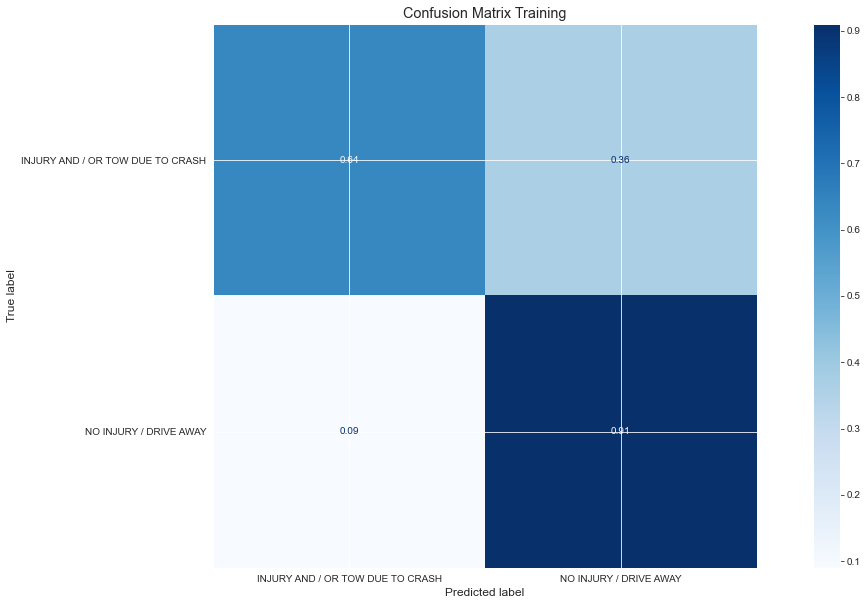

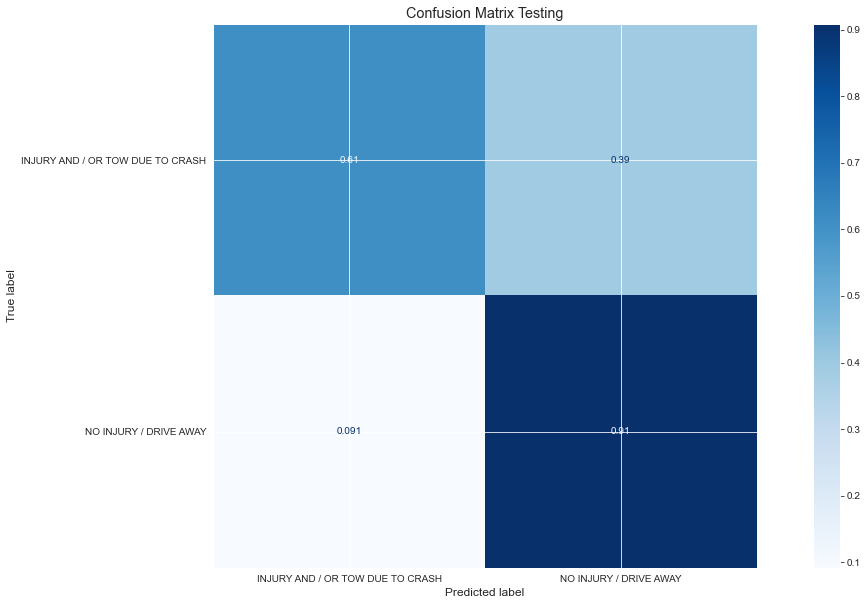

In [11]:
# Fitting, Predicting and Returning Results

run_model(log_reg, X_train_tf, X_test_tf, y_train, y_test, label = "LOGISTIC REGRESSION")

------------------------------------------------------------
K-NEAREST NEIGHBORS CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
                                  precision    recall  f1-score   support

INJURY AND / OR TOW DUE TO CRASH       0.77      0.64      0.70      9063
          NO INJURY / DRIVE AWAY       0.89      0.94      0.91     27159

                        accuracy                           0.86     36222
                       macro avg       0.83      0.79      0.81     36222
                    weighted avg       0.86      0.86      0.86     36222

------------------------------------------------------------
K-NEAREST NEIGHBORS CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
                                  precision    recall  f1-score   support

INJURY AND / OR TOW DUE TO CRASH       0.65      0.52      0.58      3894
          NO INJURY / DRIVE AWAY       0.85      0.90    

KNeighborsClassifier()

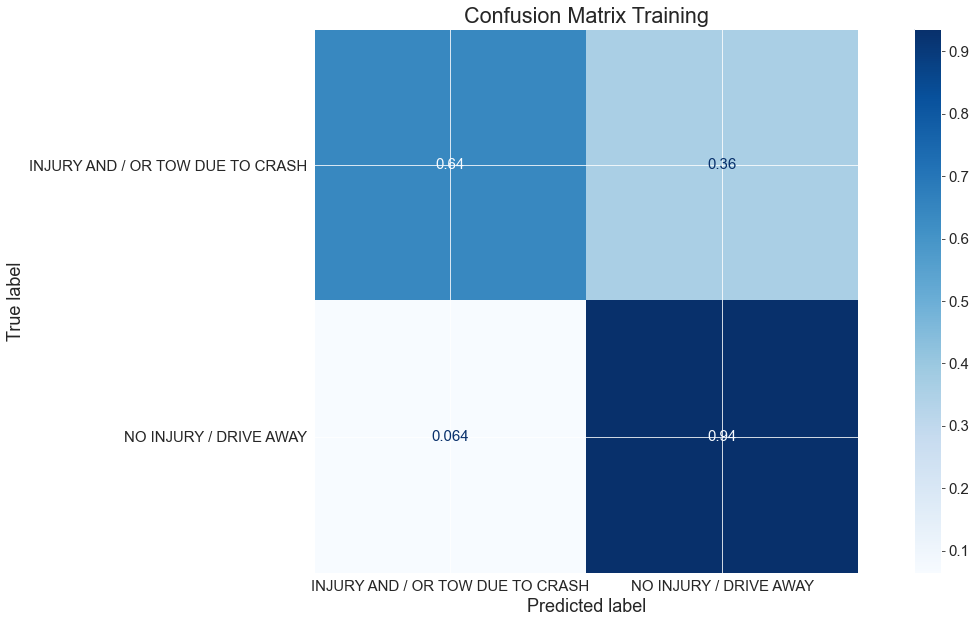

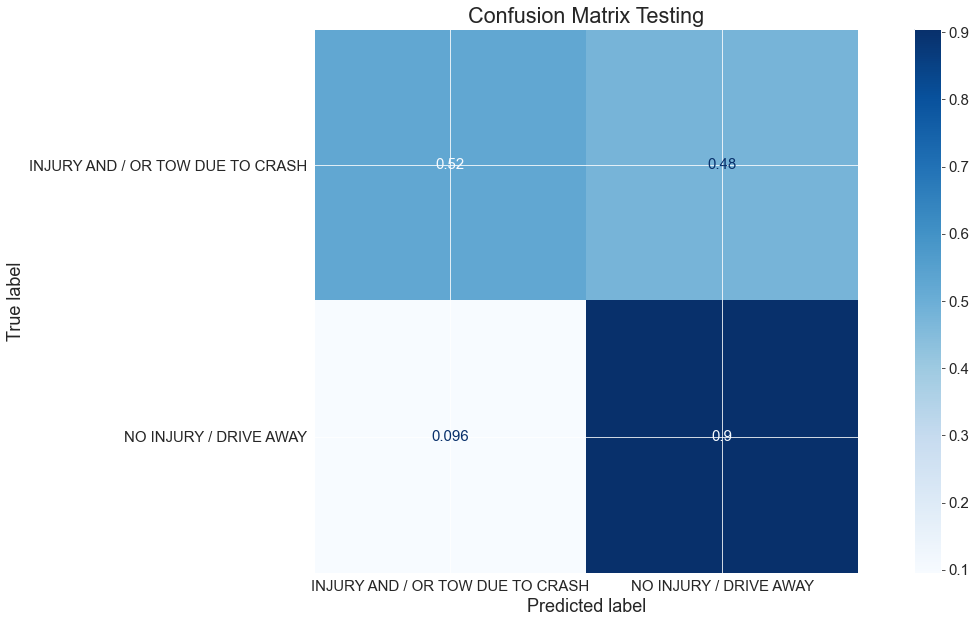

In [12]:
# Instantiate KneighborsClassifier 

knn_clf = KNeighborsClassifier()

# Fitting, Predicting and Returning Results

run_model(knn_clf, X_train_tf, X_test_tf, y_train, y_test, label = "K-NEAREST NEIGHBORS")

------------------------------------------------------------
DECISION TREE CLASSIFER CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
                                  precision    recall  f1-score   support

INJURY AND / OR TOW DUE TO CRASH       1.00      1.00      1.00      9063
          NO INJURY / DRIVE AWAY       1.00      1.00      1.00     27159

                        accuracy                           1.00     36222
                       macro avg       1.00      1.00      1.00     36222
                    weighted avg       1.00      1.00      1.00     36222

------------------------------------------------------------
DECISION TREE CLASSIFER CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
                                  precision    recall  f1-score   support

INJURY AND / OR TOW DUE TO CRASH       0.57      0.57      0.57      3894
          NO INJURY / DRIVE AWAY       0.85      

DecisionTreeClassifier()

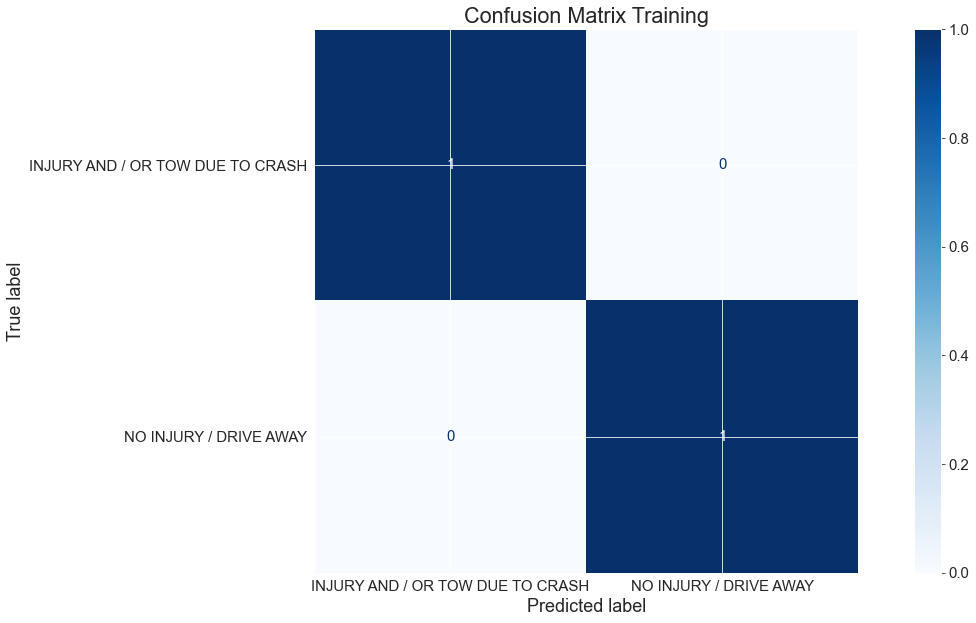

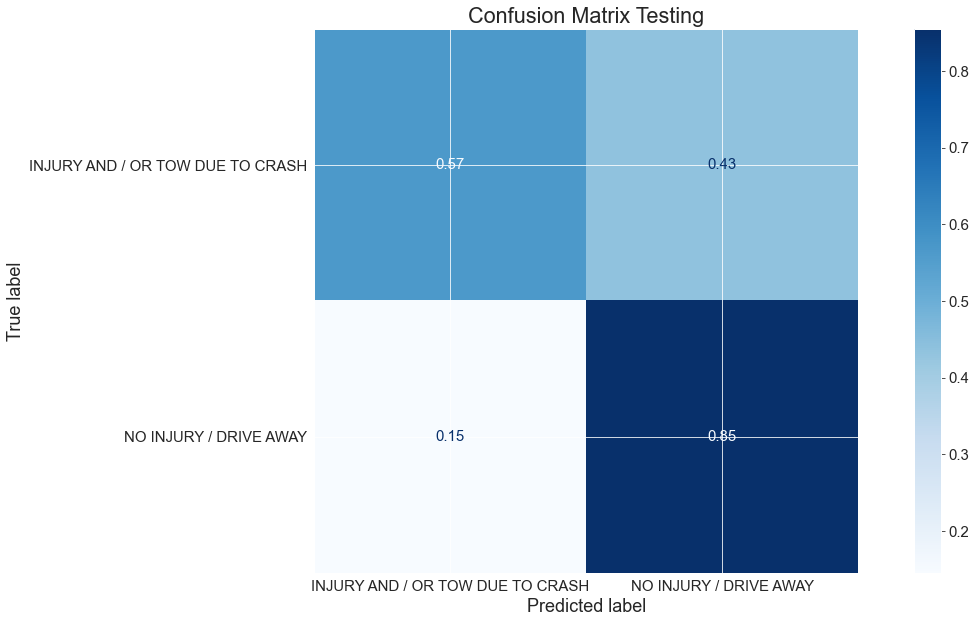

In [13]:
# Instantiate Decision Tree Classifier

classifier = DecisionTreeClassifier()  

# Fitting, Predicting and Returning Results

run_model(classifier, X_train_tf, X_test_tf, y_train, y_test, label = "DECISION TREE CLASSIFER")

------------------------------------------------------------
BAGGING CLASSIFIER CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
                                  precision    recall  f1-score   support

INJURY AND / OR TOW DUE TO CRASH       0.98      0.98      0.98      9063
          NO INJURY / DRIVE AWAY       0.99      0.99      0.99     27159

                        accuracy                           0.99     36222
                       macro avg       0.98      0.99      0.99     36222
                    weighted avg       0.99      0.99      0.99     36222

------------------------------------------------------------
BAGGING CLASSIFIER CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
                                  precision    recall  f1-score   support

INJURY AND / OR TOW DUE TO CRASH       0.64      0.63      0.64      3894
          NO INJURY / DRIVE AWAY       0.88      0.88      

BaggingClassifier(base_estimator=DecisionTreeClassifier())

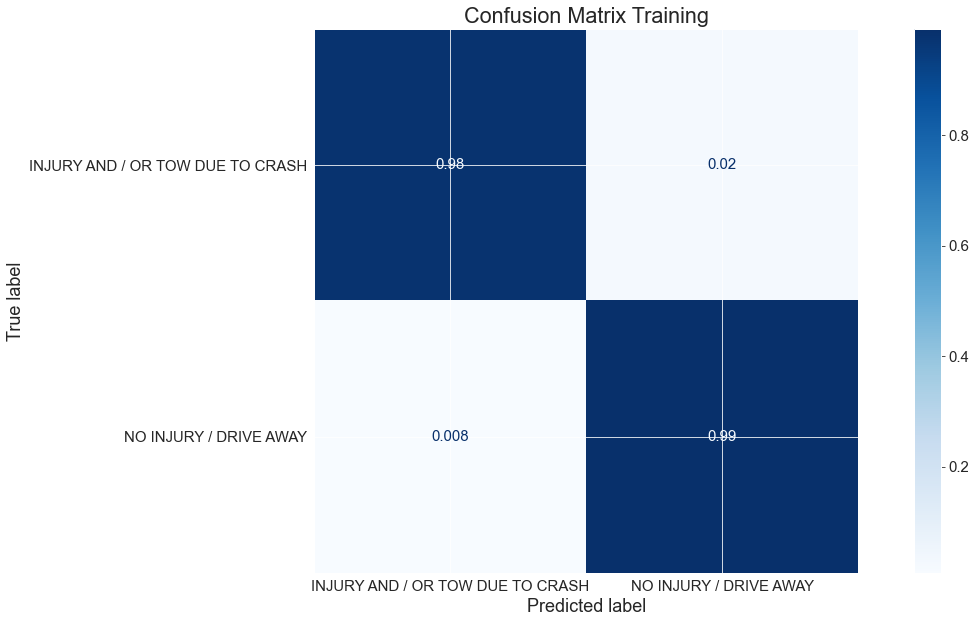

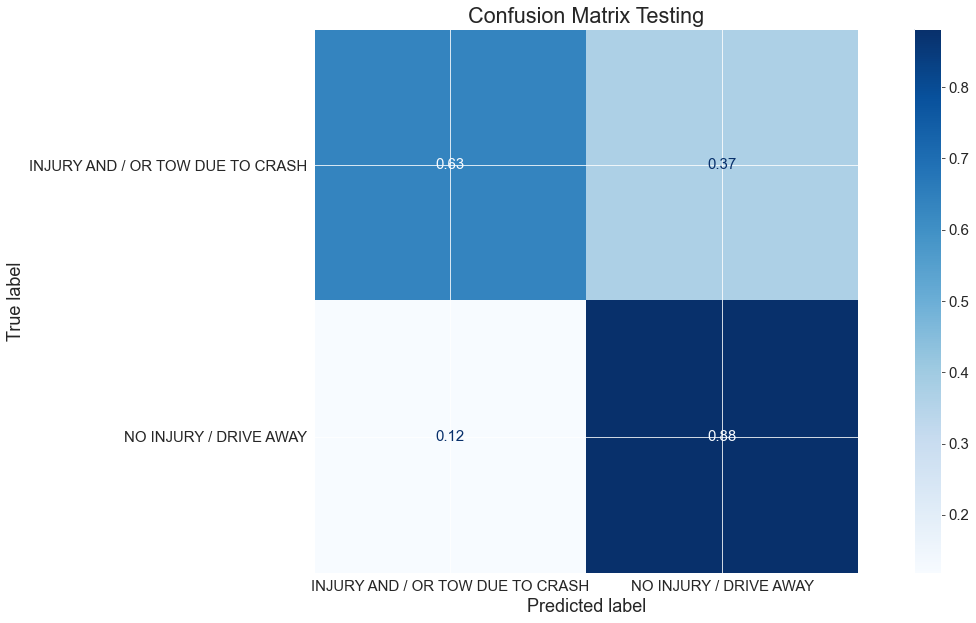

In [14]:
# Instantiate a BaggingClassifier

bagged_tree =  BaggingClassifier(DecisionTreeClassifier())

# Fitting, Predicting and Returning Results

run_model(bagged_tree, X_train_tf, X_test_tf, y_train, y_test, label = 'BAGGING CLASSIFIER')

------------------------------------------------------------
RANDOM FOREST CLASSIFIER CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
                                  precision    recall  f1-score   support

INJURY AND / OR TOW DUE TO CRASH       1.00      1.00      1.00      9063
          NO INJURY / DRIVE AWAY       1.00      1.00      1.00     27159

                        accuracy                           1.00     36222
                       macro avg       1.00      1.00      1.00     36222
                    weighted avg       1.00      1.00      1.00     36222

------------------------------------------------------------
RANDOM FOREST CLASSIFIER CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
                                  precision    recall  f1-score   support

INJURY AND / OR TOW DUE TO CRASH       0.71      0.60      0.65      3894
          NO INJURY / DRIVE AWAY       0.87    

RandomForestClassifier()

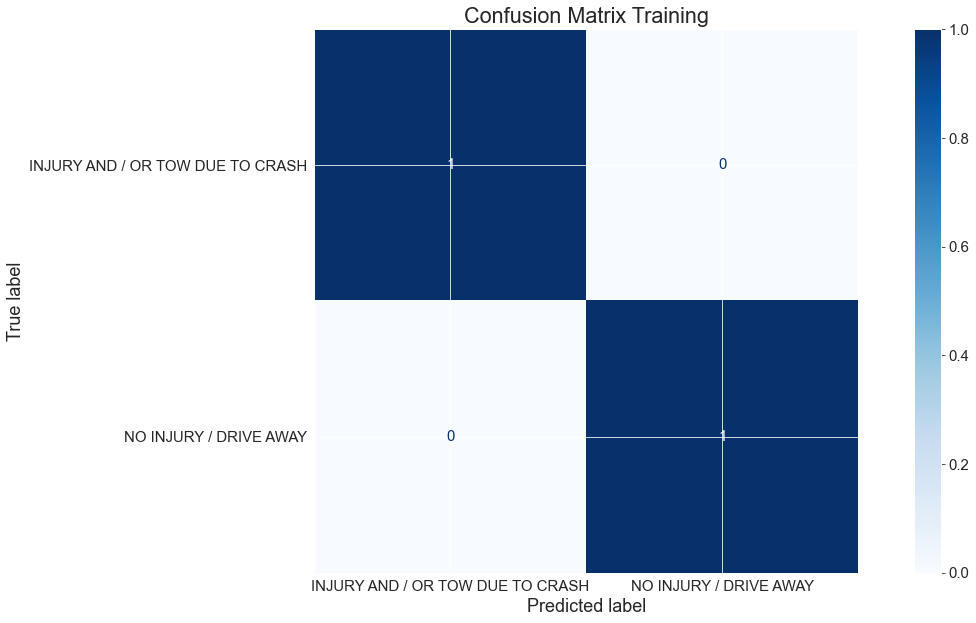

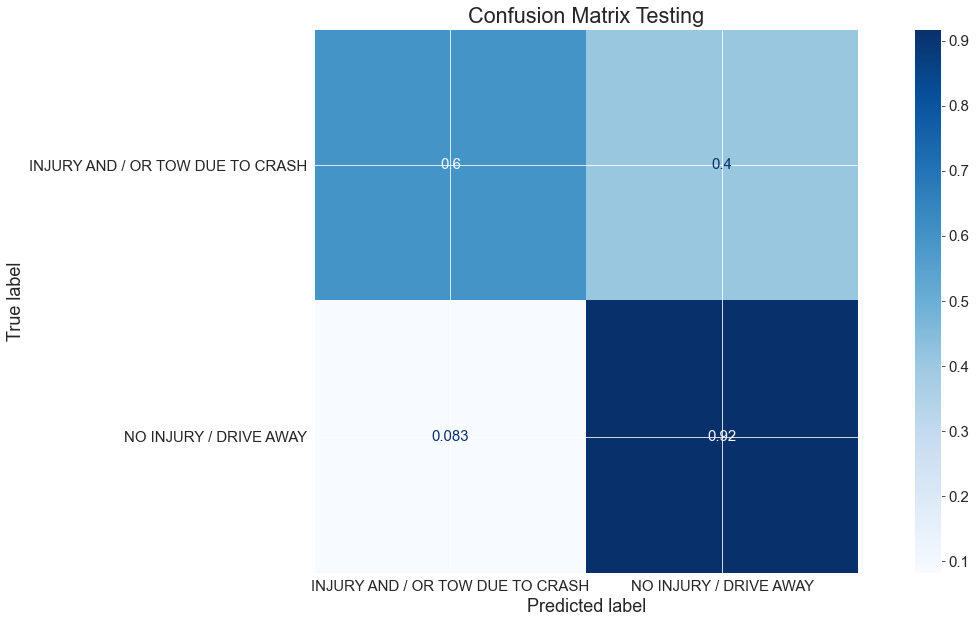

In [15]:
# Instantiate and fit a RandomForestClassifier
forest = RandomForestClassifier()

# Fitting, Predicting and Returning Results

run_model(forest, X_train_tf, X_test_tf, y_train, y_test, label = 'RANDOM FOREST CLASSIFIER')

------------------------------------------------------------
ADABOOST CLASSIFIER CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
                                  precision    recall  f1-score   support

INJURY AND / OR TOW DUE TO CRASH       0.69      0.62      0.65      9063
          NO INJURY / DRIVE AWAY       0.88      0.91      0.89     27159

                        accuracy                           0.84     36222
                       macro avg       0.78      0.76      0.77     36222
                    weighted avg       0.83      0.84      0.83     36222

------------------------------------------------------------
ADABOOST CLASSIFIER CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
                                  precision    recall  f1-score   support

INJURY AND / OR TOW DUE TO CRASH       0.70      0.61      0.65      3894
          NO INJURY / DRIVE AWAY       0.87      0.91    

AdaBoostClassifier()

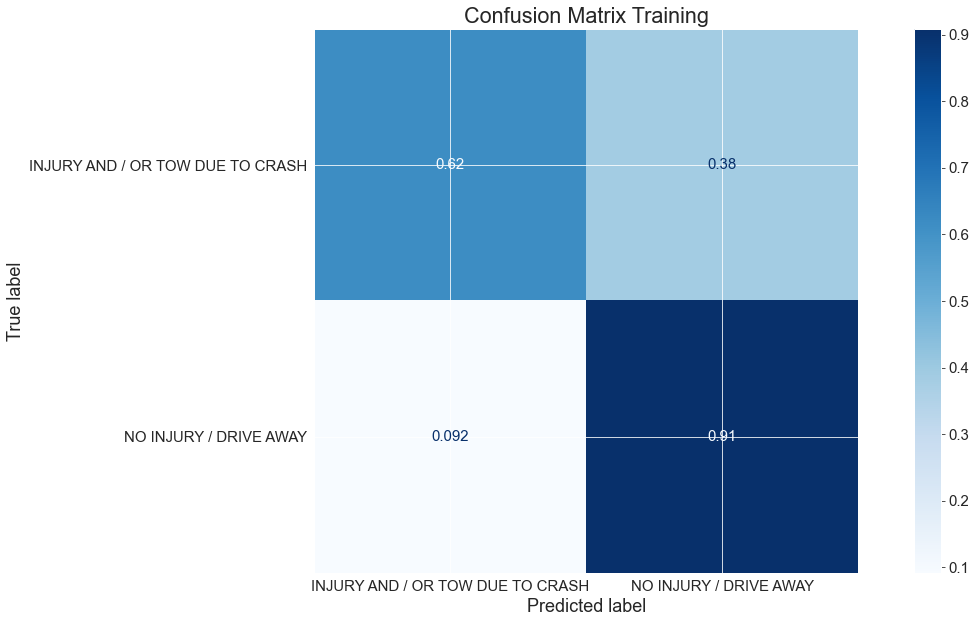

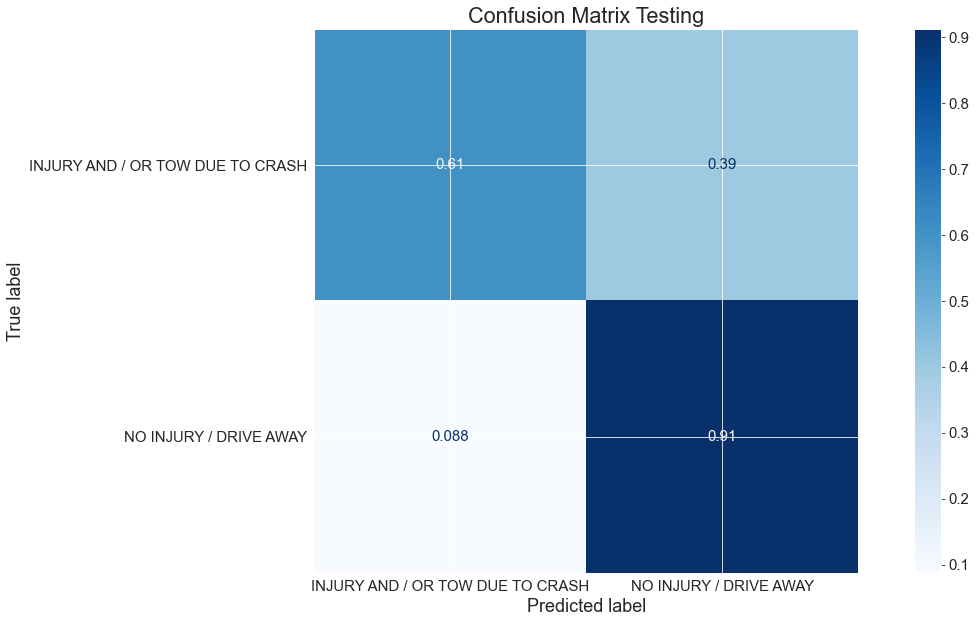

In [16]:
# Instantiate an AdaBoostClassifier

adaboost_clf = AdaBoostClassifier()

# Fitting, Predicting and Returning Results

run_model(adaboost_clf, X_train_tf, X_test_tf, y_train, y_test, label = 'ADABOOST CLASSIFIER')

------------------------------------------------------------
GRADIENT BOOSTING CLASSIFIER CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
                                  precision    recall  f1-score   support

INJURY AND / OR TOW DUE TO CRASH       0.68      0.66      0.67      9063
          NO INJURY / DRIVE AWAY       0.89      0.90      0.89     27159

                        accuracy                           0.84     36222
                       macro avg       0.79      0.78      0.78     36222
                    weighted avg       0.84      0.84      0.84     36222

------------------------------------------------------------
GRADIENT BOOSTING CLASSIFIER CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
                                  precision    recall  f1-score   support

INJURY AND / OR TOW DUE TO CRASH       0.69      0.65      0.67      3894
          NO INJURY / DRIVE AWAY       

GradientBoostingClassifier()

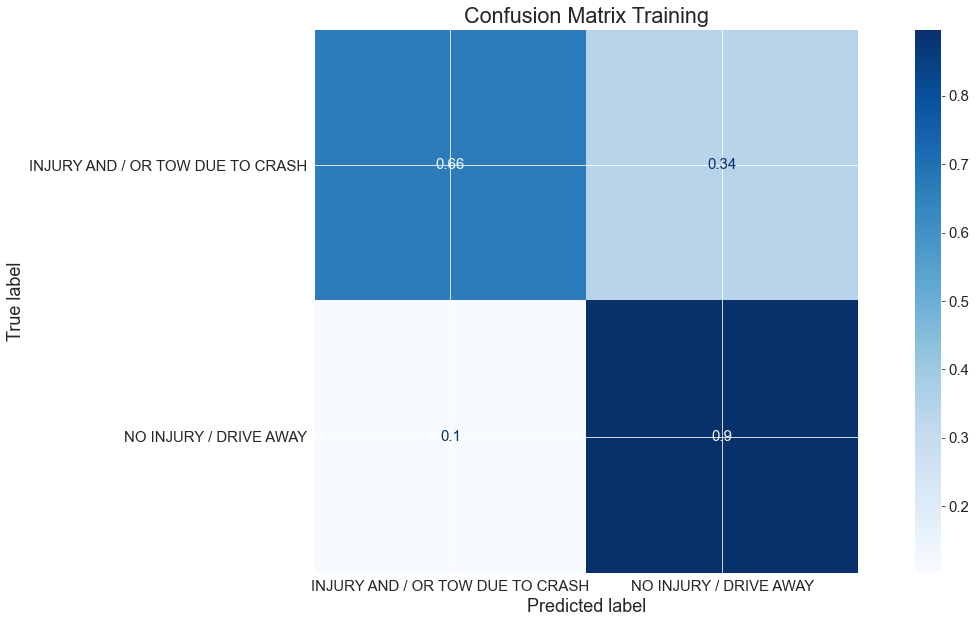

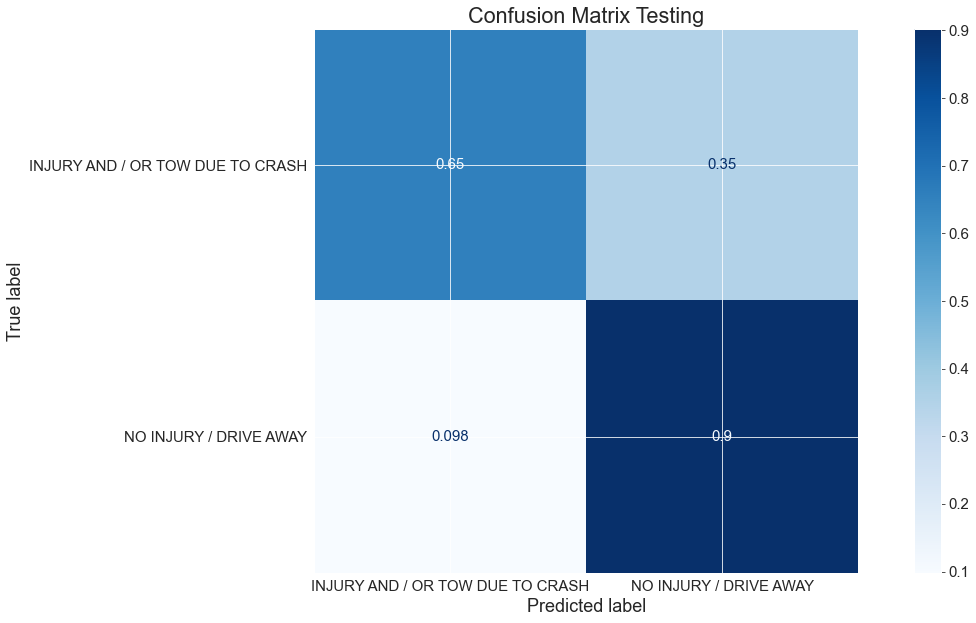

In [17]:
# Instantiate an GradientBoostingClassifier

gbt_clf = GradientBoostingClassifier()

# Fitting, Predicting and Returning Results

run_model(gbt_clf, X_train_tf, X_test_tf, y_train, y_test, label = 'GRADIENT BOOSTING CLASSIFIER')

[16:42:15] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
------------------------------------------------------------
XGB CLASSIFIER CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
                                  precision    recall  f1-score   support

INJURY AND / OR TOW DUE TO CRASH       0.76      0.70      0.73      9063
          NO INJURY / DRIVE AWAY       0.90      0.93      0.91     27159

                        accuracy                           0.87     36222
                       macro avg       0.83      0.81      0.82     36222
                    weighted avg       0.87      0.87      0.87     36222

-----------------------

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

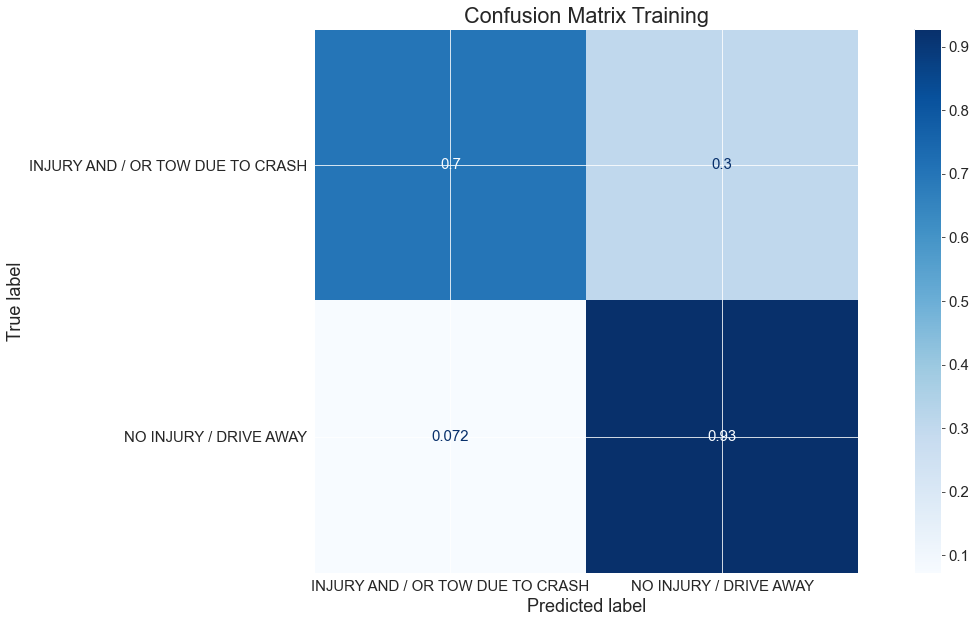

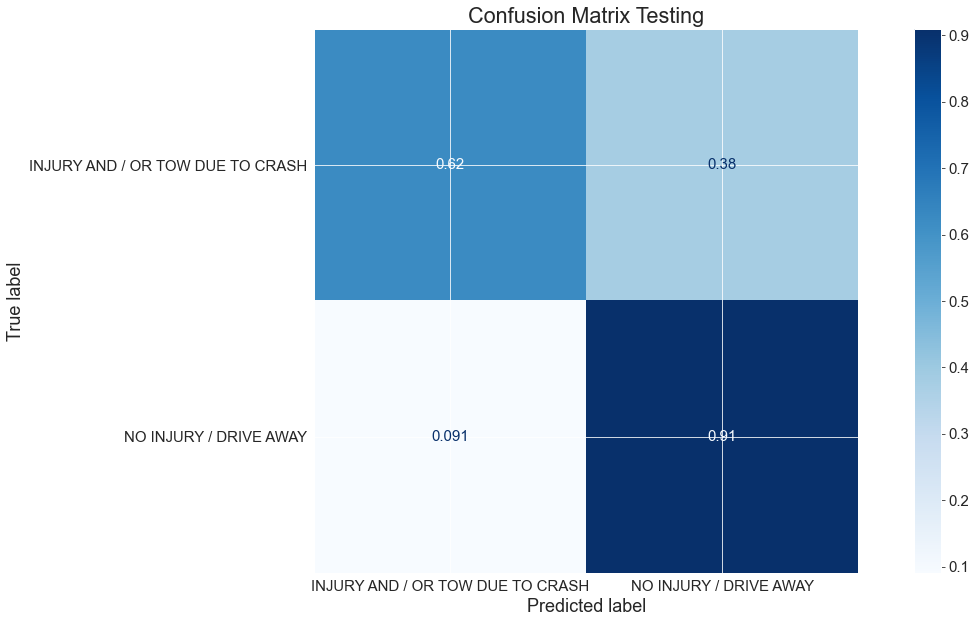

In [18]:
# Instantiate XGBClassifier

xgb_clf = XGBClassifier()

# Fitting, Predicting and Returning Results

run_model(xgb_clf, X_train_tf, X_test_tf, y_train, y_test, label = 'XGB CLASSIFIER')

------------------------------------------------------------
SUPPORT VECTOR CLASSIFICATION CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
                                  precision    recall  f1-score   support

INJURY AND / OR TOW DUE TO CRASH       0.71      0.70      0.71      9063
          NO INJURY / DRIVE AWAY       0.90      0.91      0.90     27159

                        accuracy                           0.85     36222
                       macro avg       0.81      0.80      0.80     36222
                    weighted avg       0.85      0.85      0.85     36222

------------------------------------------------------------
SUPPORT VECTOR CLASSIFICATION CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
                                  precision    recall  f1-score   support

INJURY AND / OR TOW DUE TO CRASH       0.69      0.65      0.67      3894
          NO INJURY / DRIVE AWAY     

SVC()

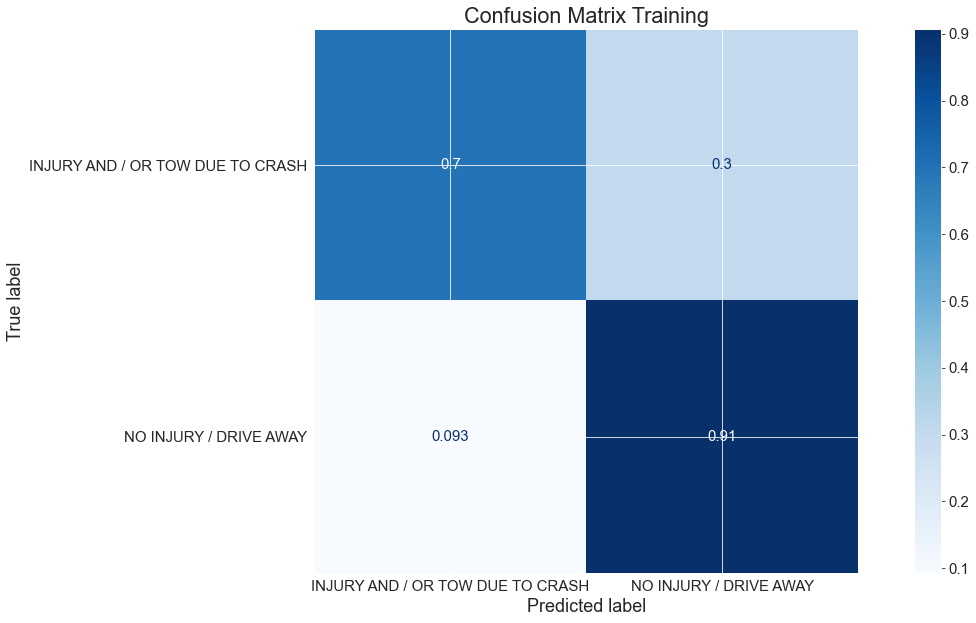

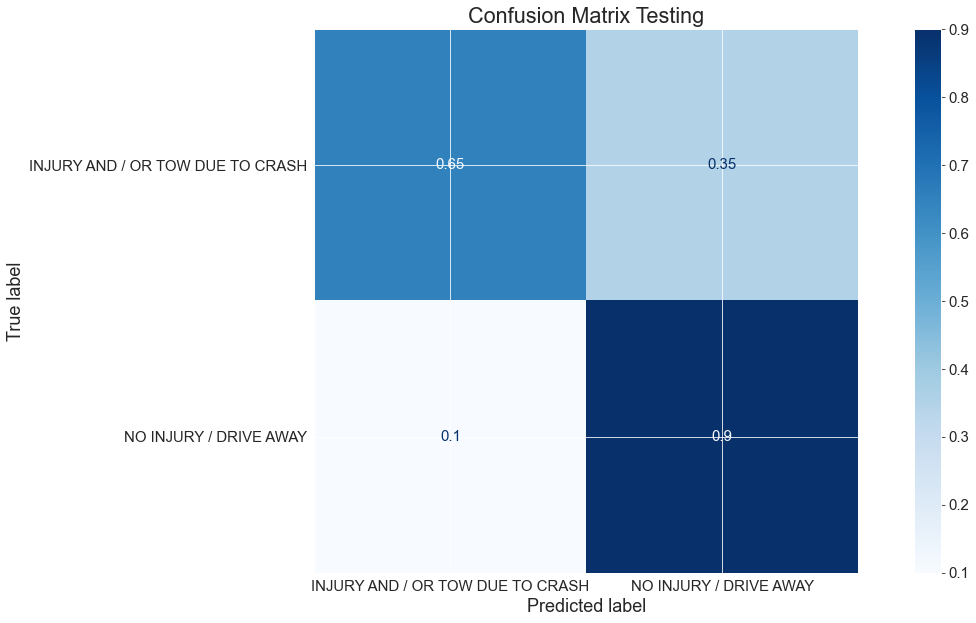

In [19]:
# Instantiate Support Vector Classification

svm_clf = SVC()

# Fitting, Predicting and Returning Results

run_model(svm_clf, X_train_tf, X_test_tf, y_train, y_test, label = 'SUPPORT VECTOR CLASSIFICATION')

In [20]:
feat_names = ['POSTED_SPEED_LIMIT', 'STREET_NO',
              'BEAT_OF_OCCURRENCE', 'NUM_UNITS',
              'CRASH_HOUR', 'CRASH_DAY_OF_WEEK',
              'CRASH_MONTH']

for a in preprocessor.transformers_[1][1].categories_:
    feat_names.extend(a.tolist())

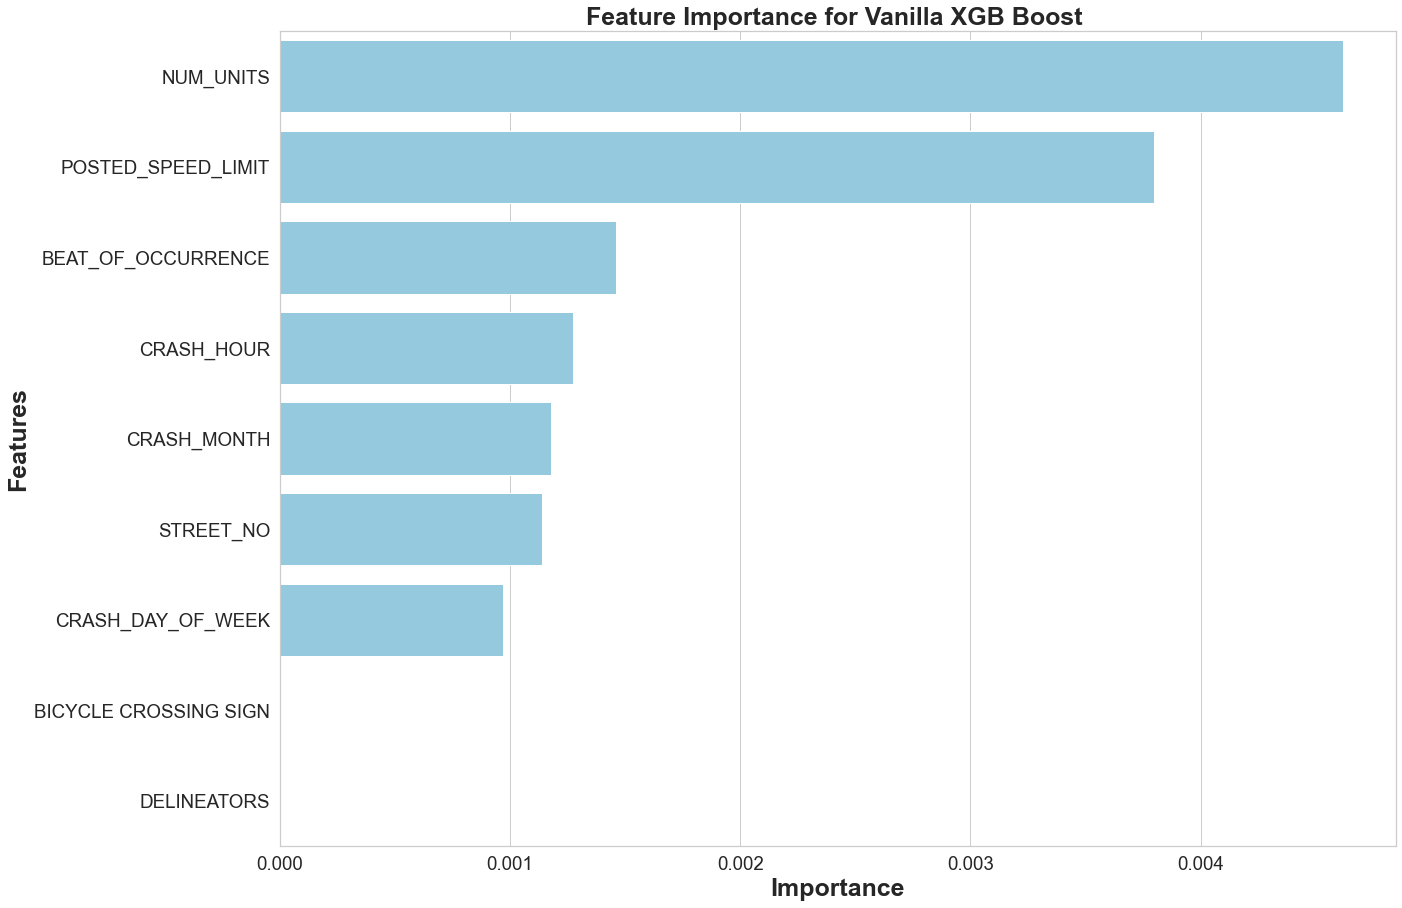

None

,Features,Gini-Importance
0,NUM_UNITS,0.004616
1,POSTED_SPEED_LIMIT,0.003797
2,BEAT_OF_OCCURRENCE,0.001459
3,CRASH_HOUR,0.001273
4,CRASH_MONTH,0.001180
5,STREET_NO,0.001141
6,CRASH_DAY_OF_WEEK,0.000970
7,BICYCLE CROSSING SIGN,0.000000
8,DELINEATORS,0.000000


In [24]:
feats = {}
for feature, importance in zip(feat_names, xgb_clf.feature_importances_[:9]):
    feats[feature] = importance
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})

sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(20,15)

sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance for Vanilla XGB Boost ', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

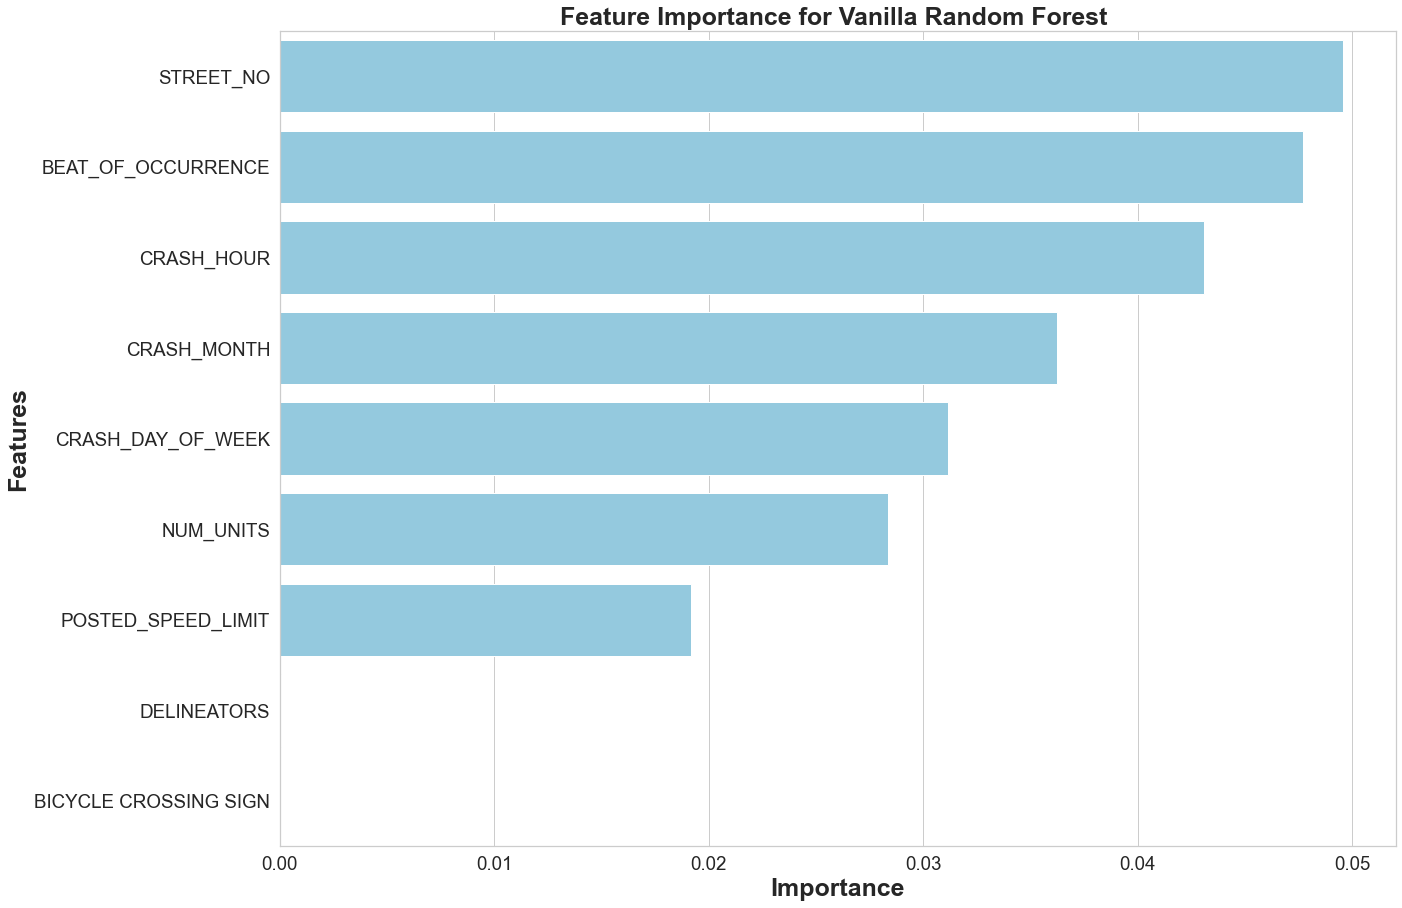

None

,Features,Gini-Importance
0,STREET_NO,0.049554
1,BEAT_OF_OCCURRENCE,0.047706
2,CRASH_HOUR,0.043074
3,CRASH_MONTH,0.036252
4,CRASH_DAY_OF_WEEK,0.031147
5,NUM_UNITS,0.028379
6,POSTED_SPEED_LIMIT,0.019175
7,DELINEATORS,0.000058
8,BICYCLE CROSSING SIGN,0.000036


In [23]:
feats = {}
for feature, importance in zip(feat_names, forest.feature_importances_[:9]):
    feats[feature] = importance
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})

sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(20,15)

sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance for Vanilla Random Forest ', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)